In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw4.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 
### Associated lectures: [Lectures 7, 8](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: See the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html).**

## Imports 

In [2]:
from hashlib import sha1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

## Instructions
<hr>
rubric={points:4}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb.
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
- Note that we are using the autograder for some of the coding questions so that you can get instant feedback. When you submit your homework on Gradescope, it will run your code on an AWS server. It's possible that all your tests pass locally but some test cases fail when you submit your work on Gradescope. Wait for your submission to run there and examine the autograder results.  If it fails, you are either submitting a wrong file or doing something unexpected somewhere in the code. If you cannot figure it out, make use of office hours and tutorials. It's important that you start early on the assignments so that we help you with such issues. Also, remember that passing the tests is not the only goal. Make sure you are understanding what exactly you are doing in each question and why you are doing it. 

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

<br><br><br><br>

## Exercise 1: implementing `DummyClassifier`
<hr>
rubric={autograde:10}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.
 
As a reminder, `DummyClassifier` is meant as a baseline and is generally a simple "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: `fit` returns nothing, `predict` returns an array whose size is the number of examples, `predict_proba` returns an array whose size is the number of examples x 2, and `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

<div class="alert alert-warning">

Solution_1
    
</div>

In [3]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """

    def fit(self, X, y):
        self.classes_, counts = np.unique(y, return_counts = True)
        self.proportions = MyDummyClassifier.normalize_counts(counts)
        self.idx_proportion = np.argmax(self.proportions)
        return None  # Replace with your code

    def predict(self, X):
        predictions = np.repeat(self.classes_[self.idx_proportion], repeats = X.shape[0])
        return predictions  # Replace with your code

    def predict_proba(self, X):
        predictions = np.tile(self.proportions, reps = (X.shape[0], 1))
        return predictions  # Replace with your code

    def score(self, X, y):
        predictions = self.predict(X)
        _, elementwise_congruency = np.unique(
            np.equal(y, predictions), 
            return_counts = True
        )
        scores = MyDummyClassifier.normalize_counts(elementwise_congruency)
        return scores[1]
    
    @staticmethod
    def normalize_counts(counts):
        return counts / np.sum(counts)

In [4]:
grader.check("q1")

q1 results: All test cases passed!
q1 - 1 message: Good job!
q1 - 2 message: Good job!
q1 - 3 message: Good job!

<br><br><br><br>

## Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be working with a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` under the data directory in this folder. As usual, please do not submit the dataset when you submit the assignment. 

In [5]:
tweets_df = pd.read_csv("data/realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [6]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [7]:
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [8]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

### 2.1 Ordering the steps
rubric={points:6}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

**Your tasks:**
1. Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
2. Add a short comment above each step to describe what the code is doing.

<div class="alert alert-warning">

Solution_2.1
    
</div>

In [9]:
# Splitting the features matrix and target variables into training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=123)

# Creating a sparse matrix of token value counts, removing stop words (ex. the)
countvec = CountVectorizer(stop_words="english")

# Instantiating a LogisticRegression object, with defined number of iterations and random_state
lr = LogisticRegression(max_iter=1000, random_state=123)

# Creating a pipieline for sequential calling of a transformer and estimator
pipe = make_pipeline(countvec, lr)

# Performing 5-fold cross-validation using the instantiated pipeline and training data, returning training and test scores
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# Calculating the mean of the results obtained from cross-validation
cross_val_results.mean()

fit_time       0.361009
score_time     0.033083
test_score     0.895098
train_score    0.976644
dtype: float64

<!-- END QUESTION -->

<br><br>

### 2.2 Baseline
rubric={autograde:2}

**Your tasks:**

1. Run 5-fold cross-validation with `DummyClassifier` on this dataset. Store the mean cross-validation score in a variable called `dummy_cv_score` given below.

> You should be able to use `MyDummyClassifier` above. But sklearn will likely complain if you try to pass it to `cross_val_score` or `cross_validate`. 

<div class="alert alert-warning">

Solution_2.2
    
</div>

In [10]:
dummy = DummyClassifier(strategy = 'most_frequent')
dummy_pipe = make_pipeline(
    countvec,
    dummy
)

dummy_cross_val_results = pd.DataFrame(
    cross_validate(dummy_pipe, X_train, y_train, return_train_score = True)
)

dummy_cv_score = dummy_cross_val_results.test_score.mean()

In [11]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 2.3 Discussion
rubric={points:4}

**Your tasks:**

1. Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
2. Above we averaged the scores from the 5 folds of cross-validation of logistic regression. Print out the 5 individual scores. Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores. 
3. Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.)
4. How does the size of this dataset (number of rows) compare to [the cities dataset](https://github.com/UBC-CS/cpsc330/blob/master/lectures/data/canada_usa_cities.csv) we have been using in class? How does this relate to the different sub-scores from the 5 folds?

<div class="alert alert-warning">

Solution_2.3
    
</div>

1. `LogisticRegression` is performing better than `DummyClassifier` in `test_score` and `train_score` for all folds. The improved `test_score` values suggest that the `LogisticRegression` model is able to better generalize the training set than the `DummyClassifier`. The `fit_time` is greater than `LogisticRegression`, likely due the larger number of parameters it must estimate. `score_time` is modestly different between the two models

2. The standard deviation of `LogisticRegression` is one order of magnitude greater than the standard deviation of `DummyRegressor`. Therefore, `DummyRegressor` is a more precise, but less accurate model than `LogisticRegressor`. The variation in the `DummyRegressor` is more likely to be due to the partitioning of the data, rather than noise contained in the data.

3. The `CountVectorizer` sparse matrix is composed of 17,340 rows. The cities dataset contains 209 rows. There will be a greater number of observations per fold to be trained on, and tested on, in Trump data set than the cities data set. Therefore, if the data is randomly collected and meets criteria that fit a the target population, it would have most examples that the model can use to generalize. Moreover, larger data sets draw more observations from a overarching population, that lead to population parameters being better estimated and outlier have a limited influence on descriptive statistics.

<!-- END QUESTION -->

<br><br>

### 2.4 Probability scores
rubric={autograde:4}

Here we train a logistic regression classifier on the entire training set: 

> Note: this is relying on the `pipe` variable from 2.1 - you'll need to redefine it if you overwrote that variable in between.

In [12]:
pipe.fit(X_train, y_train);

**Your tasks:**

1. Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Store the tweet and the associated probability in the variables `tweet` and `prob`, respectively. 

> Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

<div class="alert alert-warning">

Solution_2.4
    
</div>

In [13]:
pred_probabilities = pipe.predict_proba(X_test)

idx_max_probability = np.unravel_index(
    np.argmax(pred_probabilities, axis = None),
    pred_probabilities.shape
)

prob = pred_probabilities[idx_max_probability]
tweet = X_test.iloc[idx_max_probability[0]]

In [14]:
grader.check("q2.4")

q2.4 results: All test cases passed!

<br><br>

### 2.5 Coefficients
rubric={autograde:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `Pipeline` object as follows:

In [15]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

**Your tasks:**

Using these extracted components above, get the five words with the highest coefficients and 5 words with smallest coefficients. Store them as lists in `top_5_words` and `bottom_5_words` variables, respectively. 

<div class="alert alert-warning">

Solution_2.5
    
</div>

In [16]:
idx_vocabulary = np.ravel(np.argsort(lr_from_pipe.coef_))
vocabulary = pd.Series(vec_from_pipe.vocabulary_).reset_index().set_index(0).squeeze(axis = 1)

In [17]:
top_5_words = vocabulary[idx_vocabulary[-5:]].tolist()
bottom_5_words = list(reversed(vocabulary[idx_vocabulary[:5]].tolist()))

In [18]:
grader.check("q2.5")

q2.5 results: All test cases passed!

<br><br>

### 2.6 Running a cross-validation fold without sklearn tools 
rubric={autograde:8}

Sklearn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. 

**Your tasks:**

1. Compute logistic regression's validation score on the first fold, that is, train on 80% and validate on 20% of the training data (`X_train`) without using sklearn `Pipeline` or `cross_validate` or `cross_val_score`. Store the score of the fold in a variable called `fold_score`. Recall that `cross_validation` in `sklearn` does not shuffle the data by default.    

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split with `train_test_split` and `shuffle=False`):

In [19]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000, random_state=123)

> Meta-comment: you might be wondering why we're going into "implementation" here if this course is about _applied_ ML. In CPSC 340, we would go all the way down into `LogisticRegression` and understand how `fit` works, line by line. Here we're not going into that at all, but I still think this type of question (and Exercise 1) is a useful middle ground. I do want you to know what is going on in `Pipeline` and in `cross_validate` even if we don't cover the details of `fit`. To get into logistic regression's `fit` requires a bunch of math; here, we're keeping it more conceptual and avoiding all those prerequisites.

<div class="alert alert-warning">

Solution_2.6
    
</div>

In [20]:
X_train_fold_1, X_validate_fold_1, y_train_fold_1, y_validate_fold_1 = train_test_split(X_train, y_train, train_size = 0.8, shuffle = False)

X_train_fold_1 = countvec.fit_transform(X_train_fold_1)
X_validate_fold_1 = countvec.transform(X_validate_fold_1)

logistic_regression = lr.fit(X_train_fold_1, y_train_fold_1)

fold_score = logistic_regression.score(X_validate_fold_1, y_validate_fold_1)

In [21]:
grader.check("q2.6")

q2.6 results: All test cases passed!

<br><br><br><br>

## Exercise 3: Hyperparameter optimization
<hr>

<!-- BEGIN QUESTION -->

### 3.1 Optimizing `max_features` of `CountVectorizer`
rubric={points:2}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. 

**Your tasks:**
- Based on the plot/output, what value of `max_features` seems best? Briefly explain.

> The code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

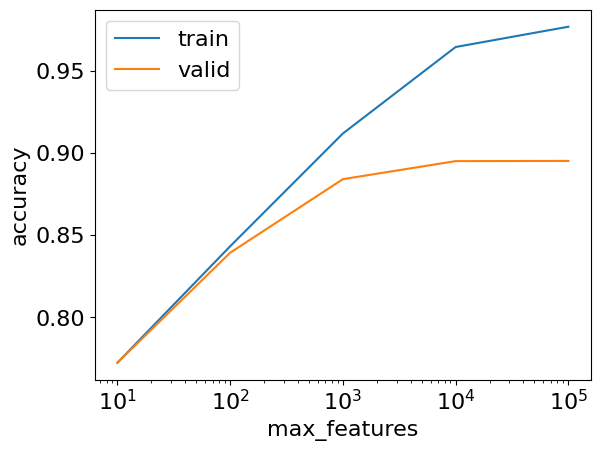

In [22]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)    
    pipe = make_pipeline(CountVectorizer(stop_words="english", max_features=mf), LogisticRegression(max_iter=1000))
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [23]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.772506,0.772491
1,100,0.843253,0.839331
2,1000,0.911779,0.884025
3,10000,0.964317,0.894983
4,100000,0.976644,0.895098


<div class="alert alert-warning">

Solution_3.1
    
</div>

The best `max_features` value is `100`.

The figure suggests that `LogisticRegression` begins to overfit on the training data with `max_features` hyperparameter values between $10^2$ and $10^3$. The model overfitting to the training data can be determine by the the divergence of the train and validation accuracy curves. At `max_features` value of $10^3$, `LogisticRegression` is not able to generalize and maintain a high accuracy with the validation set.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.2 Optimizing `C` of `LogisticRegression`
rubric={points:2}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. 

**Your tasks:**

- Based on the plot, what value of `C` seems best? Briefly explain. 

> The code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

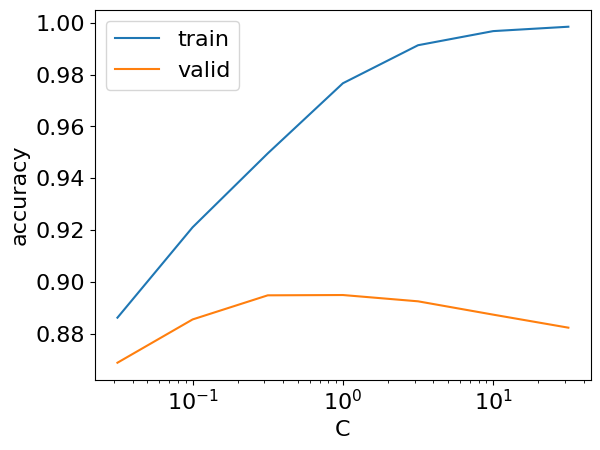

In [24]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000, C=C))    
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [25]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.031623,0.886375,0.869031
1,0.100000,0.921179,0.885698
2,0.316228,0.949640,0.894983
3,1.000000,0.976644,0.895098
4,3.162278,0.991292,0.892676
5,10.000000,0.996727,0.887543
6,31.622777,0.998414,0.882526


<div class="alert alert-warning">

Solution_3.2
    
</div>

The best `C` value is `0.031623`, based on the minimum difference between `train` and `cv` scores. There are greater `cv` scores with greater `C` values, however the growing difference between `cv` and `test` scores suggests that the model begins to overfit with greater `C` values.

<!-- END QUESTION -->

<br><br>

### 3.3 Hyperparameter optimization 
rubric={autograde:10}

Start with the pipeline `pipe` below.

**Your tasks:**
- Create a `GridSearchCV` object named `grid_search` to jointly optimize `max_features` of `CountVectorizer` and `C` of `LogisticRegression` across all the combinations of values we tried above. 
- What are the best values of `max_features` and `C` according to your grid search? Store them in variables `best_max_features` and `best_C`, respectively.  
- Store the best score returned by the grid search in a variable called `best_score`. 

> The code might be a bit slow here. Setting `n_jobs=-1` should speed it up if you have a multi-core processor.

In [26]:
pipe = make_pipeline(CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000, random_state=123))

<div class="alert alert-warning">

Solution_3.3
    
</div>

In [27]:
grid_search = GridSearchCV(pipe, param_grid = {
    'countvectorizer__max_features': [10, 100, 1000, 10_000, 100_000],
    'logisticregression__C': 10.0 ** np.arange(-1.5, 2, 0.5)
}, n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=123))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [10, 100, 1000, 10000,
                                                           100000],
                         'logisticregression__C': array([ 0.03162278,  0.1       ,  0.31622777,  1.        ,  3.16227766,
       10.        , 31.6227766 ])})

In [28]:
best_max_features = grid_search.best_params_['countvectorizer__max_features']
best_C = grid_search.best_params_['logisticregression__C']
best_score = grid_search.best_score_

In [29]:
grader.check("q3.3")

q3.3 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 3.4 Discussion 
rubric={points:4}

- Do the best values of hyperparameters found by Grid Search agree with what you found in 3.1 and 3.2? 
- Generally speaking, _should_ these values agree with what you found in parts  3.1 and 3.2? Why or why not? 

<div class="alert alert-warning">

Solution_3.4
    
</div>

They are not in agreement with the hyperparameters identified in 3.1 and 3.2. These do not have to be in agreement. 

In 3.1 and 3.2, hyperparameter optimization was treated as a univariate problem. In 3.3, hyperparameter optimization was treated as a bivariate problem which interactions between `C` and `max_features` being present. The interactions between `C` and `max_features` may find a combination that is better than what could be identified with, say, a specific `C` in `LogisticRegression` and default `max_features` in `CountVectorizer`. In other words, `C` and `max_features` can tune each others influence on model's prediction.

<!-- END QUESTION -->

<br><br>

### 3.5 Test score
rubric={autograde:2}

**Your tasks:**
- Evaluate your final model on the test set. Store the test accuracy in the variable called `test_score`.

<div class="alert alert-warning">

Solution_3.5
    
</div>

In [30]:
test_score = grid_search.score(X_test, y_test)

In [31]:
grader.check("q3.5")

q3.5 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 3.6 Discussion
rubric={points:2}

- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

<div class="alert alert-warning">

Solution_3.6
    
</div>

The test accuracy is marginally lower than the validation accuracy. The difference is due to the error present in either technical or domain specific biases present. In other words, there is intrinsic variation in our stochastic world that our model will not be able to account for. Therefore, some error is to be expected.

<!-- END QUESTION -->

<br><br><br><br>

<!-- BEGIN QUESTION -->

## Exercise 4: Very short answer questions
<hr>
rubric={points:6}

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
3. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?

<div class="alert alert-warning">

Solution_4
    
</div>

1. The `CountVectorizer` will calculate the token counts based on the test corpus. Moreover, the vocabulary extracted from the test data may be partially different to the training data. Thus, there will be words present in the test fitted `CountVectorizer` that are not present in the training data. Essentially, it will break the golden rule.

2. `predict_proba` given that it provides me greater control of what I define as, in a binary class problem, a positive or negative signal by adjusting a threshold value.

3. `GridSearchCV` is provided a set of values by the user to test from. `RandomizedSearchCV` randomly samples hyperparameter values from a defined distribution. Therefore, `GridSearchCV` is restricted by the insight the use may have on what hyperparameter values should be tested. Whereas, `RandomizedSearchCV` is restricted by a distribution of values, only reflecting the users bias towards a type of distribution, and not a rigid set of values.

<!-- END QUESTION -->

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

Congratulations on finishing the homework! 

![](img/eva-well-done.png)

